# This file:
## 1. Reads in and runs pypil to process test pupil data
## 2. Plots the resulting raw, filtered, and smoothed pupil sizes over time  

# Read in pypil with __init__ modified appropriately for the test data

In [87]:
from scipy import signal
import os
import re
import numpy as np
import pandas as pd
from io import StringIO
import warnings


class pypil(object):
    """
    This class follows the pupil preprocessing guidelines stipulated in Kret & Sjak-Shie (2018).

    This calss is structured such that after reading in the data, one should follow three simple steps 
    (called phases) as describe in Kret & Sjak-Shie (2018):

    1.  pypil.prepare_phase(): This method organizes the data into and managable format removing all
        the unnecessary components produced by the eyetracker

    2.  pypil.filter_phase(): This method performs a series of filters on the data to smooth the data and start
        filtering out the bad data points

    3.  pypil.process_valid_samples(): The final method uses the filtered data to make inferences about which data 
        points are likely due to noise (based on either physical impossibilities or logic; see Kret & Sjak-Shie, 
        2018, see Figure 2 and 4). Then removes these values and imputes the value give the autocorrelation and 
        overall path trajectory.  
    """

    def __init__(self, filename):
        super(pypil, self).__init__()
        self.filename = filename
        self.subjectid = '021'
        self.sf = 250 # Sampling frequency (aka Hz) that you want to be sampled at (if downsampling)
        self.include_pupil = False  # Don't include until you have met all conditions
        self.data_dir = '/Users/emilydial/Library/Mobile Documents/com~apple~CloudDocs/Harvard/Phelps Lab/Pypil/' 
        self.event_list = ['start_block','fixation','lottery',\
            'choice','confirmation'] 
        self.relevant_list = ['start_block','fixation','lottery',\
            'choice','confirmation']
        self.bad_strings = ['SFIX', 'SSACC', 'EFIX', 'ESACC', 'SBLINK', 'EBLINK', 'END', 'INPUT',
                       'START', 'PRESCALER', 'VPRESCALER', 'PUPIL', 'EVENTS', 'SAMPLES'] # TODO: where is the blank screen, and how about drift check? 
        self.start_baseline_str = 'baseline_onset'
        self.end_baseline_str = 'baseline_end'
        self.start_blocks_str = 'block 0'
        self.end_blocks_str = 'block 3'
        self.redundant_col = ['dots', 'inter_pupil', 'valid_time']
        self.redundant_col_first_row = ['x','y','pupil','event','is_valid','smoothed_interp_pupil','inter_pupil']
        self.event_str = 'event'
        self.block_str = 'block'
        self.trial_str = 'trial'
        self.number_of_columns_for_message = [
                                          'MSG', 'time', 'ID_txt', 'ID', 'day_txt', 'day', 'block_txt', 'block', 'trial_txt', 'trial', 'event_txt', 'event', 'action', \
                                              'ph1', 'ph2', 'ph3', 'ph4', 'ph5', 'ph6', 'ph7', 'ph8']
        self.separation_rule = ' |\t'
        self.start_fixation_str = 'fixation'
        self.merged_data_columns = ['ID', 'block', 'trial', 'event']
        self.time_str = 'time'
        self.fraction_of_sampling_rate = 0.5

    def __eq__(self, other) : 
            return (self.__dict__ == other.__dict__).all()

    def read_contents(self):
        """
        read in all lines in the ASC file
        """
        with open(self.filename, 'r') as f:
            self.content = f.readlines()
            # detect whether the eyelink rate was stored in the first 200 lines (an arbitrary number)
            rate_line = [x for x in self.content[:200] if 'RECCFG CR ' in x] 
            baseline_line = [x for x in self.content if self.start_baseline_str in x]
            if not rate_line:
                rate_line = [x for x in self.content if 'RECCFG CR ' in x]
            if rate_line:
                self.eyelinkrate = int(re.search(" (\d{3,4}) ", rate_line[0]).group())
            if not  baseline_line:
                self.contain_baseline = 0
            if baseline_line:
                self.contain_baseline = 1

    def organize_baseline(self):
        """
        save message and pupil csv files during baseline
        """
        if self.contain_baseline:
            start_baseline = np.where(np.array([self.start_baseline_str in x for x in self.content]))[0]
            end_baseline = np.where(np.array([self.end_baseline_str in x for x in self.content]))[0]
            baseline_file = self.content[start_baseline[0]:(end_baseline[-1]+1)]
        if self.contain_baseline:
            # first save the bad string file
            self.baseline_badstring_file = pd.Series(baseline_file)[pd.Series(baseline_file).str.contains("|".join(self.bad_strings))]   
            self.baseline_badstring_file.to_csv(os.path.join(self.data_dir, '{}_baseline_badstring.csv'.format(self.subjectid)), index=False)
            baseline_file = pd.Series(baseline_file)[~pd.Series(baseline_file).str.contains("|".join(self.bad_strings))]
            self.baseline_pupil_str = np.array(baseline_file)[['baseline' not in x for x in baseline_file]]
            
            self.baseline_pupil_data = pd.read_csv(StringIO('\n'.join(self.baseline_pupil_str)), names=[
                                        'time', 'x', 'y', 'pupil', 'dots'],
                                        usecols=['time', 'x', 'y', 'pupil', 'dots'], na_values=['   .'], sep='\t', engine='python')
            self.baseline_pupil_data.to_csv(os.path.join(self.data_dir, '{}_baseline_pupil_RAW.csv'.format(self.subjectid)), index=False) 

    # this function is also task specific
    def organize_contents(self):
        """
        save message and pupil csv files
        """

        start_blocks = np.where(np.array([self.start_blocks_str in x for x in self.content]))[0]
        end_blocks = np.where(np.array([self.end_blocks_str in x for x in self.content]))[0]
        small_file = self.content[start_blocks[0]:(end_blocks[-1]+1)]
        
        # first save the bad string file in case future analysis need
        self.small_badstring_file = pd.Series(small_file)[pd.Series(small_file).str.contains("|".join(self.bad_strings))]   
        self.small_badstring_file.to_csv(os.path.join(self.data_dir, '{}_badstring.csv'.format(self.subjectid)), index=False)
        
        # Remove all of the fixation, saccade, and blink messages
        small_file = pd.Series(small_file)[~pd.Series(small_file).str.contains("|".join(self.bad_strings))]
        
        # Extract, Fix, and Save Messages
        
        self.messages = np.array(small_file)[['MSG' in x for x in small_file]] # previously MSG
        self.message_str = []

        for line in self.messages:
            # add blockid and trialid
            if not self.block_str in line:
                split_strings = line.split()
                if not self.trial_str in line:
                    split_strings.insert(2, 'block 999 trial 999')
                else:
                    split_strings.insert(2, 'block 999')
                line = ' '.join(split_strings)
            else:
                if not self.trial_str in line:
                    split_strings = line.split()
                    split_strings.insert(4, 'trial 999')
                    line = ' '.join(split_strings)
            self.message_str.append(line)

        self.message_data = pd.read_csv(StringIO('\n'.join(self.message_str)), names=self.number_of_columns_for_message, # placeholder to have enough entries so that it wont throw errors
                                          na_values=['nan'], sep=' |\t', engine='python')
        # replace 999 with NaN
        self.message_data[self.block_str] = self.message_data[self.block_str].replace(999, np.nan)
        self.message_data[self.trial_str] = self.message_data[self.trial_str].replace(999, np.nan)
        self.message_data.to_csv(os.path.join(self.data_dir, '{}_message_RAW.csv'.format(self.subjectid)), index=False)

        
        # Extract, Fix, and Save Pupil Data
        self.pupil_str = np.array(small_file)[['MSG' not in x for x in small_file]]
        self.pupil_data = pd.read_csv(StringIO('\n'.join(self.pupil_str)), names=[
                                        'time', 'x', 'y', 'pupil', 'dots'],
                                        usecols=['time', 'x', 'y', 'pupil', 'dots'], na_values=['None'], sep='\t', engine='python')
        self.pupil_data.to_csv(os.path.join(self.data_dir, '{}_pupil_RAW.csv'.format(self.subjectid)), index=False) # not quite sure how I get away with all the drift correct?
        # self.merged_data.ffill(inplace=True) 
        
    def down_sample(self):
        """
        downsample data to a frequency of self.sf from self.eyelinkrate
        """
        self.pupil_data_raw = self.pupil_data.copy(deep=True)
        self.pupil_data = self.pupil_data.loc[pd.RangeIndex(
            self.pupil_data.index[0], self.pupil_data.index[-1], step=int(self.eyelinkrate / self.sf))]
        self.pupil_data.reset_index(inplace=True)
        self.pupil_data.to_csv(os.path.join(self.data_dir, '{}_pupil_RAW_downsample.csv'.format(self.subjectid)), index=False)

        if hasattr(pypil, 'merged_data'):
            
            self.merged_data_raw = self.merged_data.copy(deep=True)
            self.merged_data = self.merged_data.loc[pd.RangeIndex(
                self.merged_data.index[0], self.merged_data.index[-1], step=int(self.eyelinkrate / self.sf))]
            self.merged_data.reset_index(inplace=True)
            self.merged_data.to_csv(os.path.join(self.data_dir, '{}_merged_pupil_RAW_downsample.csv'.format(self.subjectid)), index=False)
        
        if hasattr(pypil, 'baseline_pupil_data'):
            
            self.baseline_pupil_data_raw = self.baseline_pupil_data.copy(deep=True)
            self.baseline_pupil_data = self.baseline_pupil_data.loc[pd.RangeIndex(
                self.baseline_pupil_data.index[0], self.baseline_pupil_data.index[-1], step=int(self.eyelinkrate/self.sf))]
            self.baseline_pupil_data.reset_index(inplace=True)
            self.baseline_pupil_data.to_csv(os.path.join(self.data_dir, '{}_baseline_pupil_RAW_downsample.csv'.format(self.subjectid)), index=False)

    # def interpolate(self):
    #     """
    #     interpolate the data to make up for missing values
    #     """
    #     # Interpolation
    #     self.inter_pupil = self.merged_data.pupil.copy(deep=True)
    #     self.inter_pupil.rename('inter_pupil', inplace=True)
    #     self.inter_pupil.replace(0, np.NaN, inplace=True)
    #     self.merged_data = self.merged_data.join(self.inter_pupil)
    #     if self.merged_data.inter_pupil.isna().mean() > .3:
    #         self.include_pupil = False
    #     else:
    #         self.merged_data.inter_pupil.interpolate(inplace=True)

    def read_data(self):
        """
        read in cleaned message, pupil and merged data
        Haoxue Aug: in theory we do not need this part since it should be taken care of in the wrapper prepare_data()
        """
        try:
            self.message_data = pd.read_csv(os.path.join(self.data_dir, '{}_message_RAW.csv'.format(self.subjectid)))
            self.pupil_data = pd.read_csv(os.path.join(self.data_dir, '{}_pupil_RAW.csv'.format(self.subjectid)))
            self.merged_data = pd.read_csv(os.path.join(self.data_dir, '{}_merged_pupil_RAW.csv'.format(self.subjectid)))
        except:
            raise Exception('At least one data file does not exist in the current folder. Please double check and/or rerun the pipeline.')

        try:
            self.baseline_pupil_data = pd.read_csv(os.path.join(self.data_dir, '{}_baseline_pupil_RAW.csv'.format(self.subjectid)))
        except:
            raise Exception('There is no baseline_pupil_data in the current folder. Please double check and/or rerun the pipeline.')
           
    def mess_pupil_merge(self):
        '''
        merge pupil and message data
        Note: the name has '2' in due to that in an early version we want to distinguish this file with Deshawn's version where deep/shallow copy was not distinguished
        '''

        print('This will take some time...')
        
        self.message_data_trial_start = self.message_data[self.message_data.event == self.start_fixation_str]
        self.message_data_trial_start = self.message_data_trial_start.append(self.message_data.tail(1)) # append will be deprecated in the future

        # generate merged data file with same rows as the puil data (not fillin the pupil data yet)
        # in my data, I also did not put in the behavioral data / task attribute here yet.
        self.merged_data = pd.DataFrame(columns=self.merged_data_columns, 
                                        index=self.pupil_data.index)
        # fill in the subjectid                                    
        self.merged_data.ID.iloc[0] = self.subjectid

        for idx in range(self.message_data_trial_start.shape[0]-1):
            # get block and trial info from message data
            curr_b, curr_t = self.message_data_trial_start.iloc[idx][[self.block_str, self.trial_str]]
            trial_time_range = \
                [self.message_data_trial_start.iloc[idx][self.time_str], \
                    self.message_data_trial_start.iloc[idx+1][self.time_str]]
            trial_idx_range = \
                pd.RangeIndex(self.pupil_data.time.sub(trial_time_range[0]).abs().idxmin(),\
                    self.pupil_data.time.sub(trial_time_range[1]).abs().idxmin())

            self.merged_data.block.loc[trial_idx_range] = curr_b
            self.merged_data.trial.loc[trial_idx_range] = curr_t

        # Haoxue Aug 1: the start index and end index of each trial is good. However when it comes to event locked, sometimes event will be missed since it can not find the exact time lock
        for individual_event in self.event_list:
            individual_time = self.message_data.time[self.message_data.event == individual_event]
            individual_idx = [self.pupil_data.time.sub(x).abs().idxmin() for x in individual_time]
            # # for the future: should change how much it increases after 
            # individual_idx = pd.RangeIndex([self.pupil_data.time.sub(x).abs().idxmin() for x in individual_time,\
            #     self.pupil_data.time.sub(x).abs().idxmin()+4 for x in individual_time])
            
            # not sure why Deshawn wants it to be one option and one option plus one.  - Aug 1 Now I think I know.
            # I wonder what is the structure of individual_idx... 
            # I guess I could change it later if needed.
                # pd.RangeIndex([self.pupil_data.time.sub(individual_time).abs().idxmin(),\
                #     self.pupil_data.time.sub(individual_time).abs().idxmin()+1])

            self.merged_data.event.loc[self.pupil_data.index.isin(individual_idx)] = individual_event

        self.merged_data.ffill(inplace=True)
        # after entering the fields according to the behavioral data (setting), merge it with pupil data (size goes up)
        self.merged_data = self.pupil_data.join(self.merged_data)
        # only save the part from the start of the first trial to the end of the last trial
        # self.merged_data = self.merged_data.loc[pd.RangeIndex(inds[0][0][0], inds[-1][-1][-1])]
        self.include_pupil = True
        #self.merged_data.corrected_pupil = self.merged_data.inter_pupil / self.merged_data.inter_pupil.mean()
        self.merged_data.to_csv(os.path.join(self.data_dir, '{}_merged_pupil_RAW.csv'.format(self.subjectid)), index=False)
        
        #create file with only relevant events
        filt_relevant_events = (self.merged_data[self.event_str].isin(self.relevant_list))
        self.merged_data_relevant = self.merged_data[filt_relevant_events]
        self.merged_data_relevant.to_csv(os.path.join(self.data_dir, '{}_merged_pupil_RAW_relevant.csv'.format(self.subjectid)), index=False)
        
    def prepare_phase(self, overwrite=False):
        '''
        Read in, organize, create pd.DataFrames pupil, messages, and a merged datasets.
        If these files are already created then it can overwrite them but will not by
        default. You will receive a message indicating whether it was CREATED,
        EXISTED, or OVERWRITTEN.

        This phase will be unique for each eyetracker and potentially each study. As such this provides a
        description for what this phases should result in. Additionally there is an example for what it for
        an Eyelink eyetracker with messages that specify the stimuli on screen as well as the trial number.

        At the conclusion of this phase the main object is expected to have the following:
            self.message_data = pandas.DataFrame with the messages and corresponding time stamps
            self.pupil_data = pandas.DataFrame with the pupil data and corresponding time stamps
            self.merged_data = pandas.DataFrame with the messages merged with the timestamps

        self.merged_data can have more properties but these should be a minimum.

        '''
        self.overwrite = overwrite
        if not hasattr(self, 'merged_data') or not isinstance(self.merged_data, pd.DataFrame):
            'Need to raise and assertion here because you need to have a pd.DataFrame called merged_data'
        elif not all(pd.Series(['time', 'pupil']).isin(self.merged_data.columns)):
            'Another assertion you need to have the following columns in your data frame\'time\' and \'pupil\''

        if (not all([os.path.exists(os.path.join(self.data_dir, '{}_message_RAW.csv'.format(self.subjectid))),\
            os.path.exists(os.path.join(self.data_dir, '{}_pupil_RAW.csv'.format(self.subjectid))),\
                os.path.exists(os.path.join(self.data_dir, '{}_merged_pupil_RAW.csv'.format(self.subjectid))),\
                    os.path.exists(os.path.join(self.data_dir, '{}_baseline_pupil_RAW.csv'.format(self.subjectid)))])) or self.overwrite:
            self.read_contents()
            self.organize_baseline()
            self.organize_contents()
            if overwrite:
                print('{} data were OVERWRITTEN'.format(self.subjectid))
            else:
                print('{} data were CREATED'.format(self.subjectid))
            self.mess_pupil_merge()
            # Haoxue: I believe that downsample is mostly because we want to save computational resource. currently move it down mess_puipl_merge2 and see how it goes.
            self.down_sample()
        else:
            print('{} data EXISTED'.format(self.subjectid))

            self.read_data()

    def default_filter_settings(self):
        '''
        Returns the default filter settings according to Kret & Sjak-Shie (2018) as a dictionary.

        Once run you may adjust specific settings but adjusting the value in the self.filter_settings
        dictionary.
        '''
        filter_settings = dict()

        # ----------------------------------------------------------------------
        # Pupil range filter criteria:

        # The minimum and maximum allowable pupil size:
        # filter_settings['pupil_diameter_min'] = 1.5
        # filter_settings['PupilDiameter_Max'] = 9

        # If your eytrack does not record in mm then the following are suggested:
        filter_settings['pupil_diameter_min'] = .1
        filter_settings['pupil_diameter_max'] = np.Inf

        # ----------------------------------------------------------------------
        # Isolated sample filter criteria:

        # 'Sample-islands' are clusters of samples that are temporally separated
        # from other samples. The minimum distance used to consider
        # samples 'separated' is specified below:
        filter_settings['island_filter_seperation_ms'] = 40  # [ms]

        # When clusters are separated, they need to have the minimum size
        # specified below. Sample islands smaller than this temporal width and
        # separated from other samples by the distance mentioned above are
        # marked as invalid.
        filter_settings['island_filter_island_width_ms'] = 50  # [ms]

        # ----------------------------------------------------------------------
        # Dilation speed filter criteria:

        # The number of medians to use as the cutoff threshold when applying
        # the speed filter:
        filter_settings['dialation_speed_filter_MAD_multiplier'] = 16  # [# of MADs]

        # Only calculate the speed when the gap between samples is smaller than
        # the distance specified below:
        filter_settings['dialation_speed_filter_max_gap_ms'] = 200  # [ms]

        # ----------------------------------------------------------------------
        # Edge removal filter criteria:

        # Sometimes gaps in the data after the dilation speed filter feature
        # artifacts at their edges. These artifacts are not always removed by
        # the dilation speed filter; as such, samples around these gaps may
        # also need to be marked as invalid. The settings below indicate when a
        # section of missing data is classified as a gap (samples around these
        # gaps are in turn rejected).
        filter_settings['gap_min_width'] = 75  # [ms]
        filter_settings['gap_max_width'] = 2000  # [ms]

        # The settings below indicate the section right before the start of a
        # gap (the backwards padding distance) and the section right after a
        # gap (the forward padding distance), in ms, within which samples are
        # to be rejected:
        filter_settings['gap_padding_backward'] = 50  # [ms]
        filter_settings['gap_padding_forward'] = 50  # [ms]

        # ----------------------------------------------------------------------
        # Deviation filter criteria:

        # At this point a subset of the original samples are marked as valid,
        # these samples are the input for this filter.

        # The dilation speed filter will not reject samples that do not feature
        # outlying speeds, such as is the case when these samples are clustered
        # together. As such, a deviation from a smooth trendline filter is
        # warranted. The setting below stipulates how many passes the deviation
        # filter will make:
        filter_settings['residuals_filter_passes'] = 4  # [# of passes]

        # After each pass, all input samples that are outside of the threshold,
        # which is the multiple stated below of the median, are removed. Note
        # that all input samples are considered (including samples which may
        # have been rejected by the previous deviation filter passes).
        filter_settings['residuals_filter_MAD_multiplier'] = 16  # [# of MADs]

        # At each pass, a smooth continuous trendline is generated using the
        # data below, from which the deviation is than calculated and used as
        # the filter criteria:
        filter_settings['residuals_filter_interpFs'] = 250  # [Hz]
        nyq = filter_settings['residuals_filter_interpFs'] / 2
        filter_settings['residuals_filter_lowpassCF'] = 16  # [Hz]
        filter_settings['residuals_filter_lowpassB'],\
            filter_settings['residuals_filter_lowpassA'] = signal.butter(1,
                                                                         filter_settings['residuals_filter_lowpassCF'] /
                                                                         (nyq))

        # ----------------------------------------------------------------------
        # Keep filter data:

        # The following flag enables/disables the storage of the intermediate
        # filter data, set to false to save memory and improve plotting
        # performance:
        filter_settings['keep_filter_data'] = True

        # ----------------------------------------------------------------------

        self.filter_settings = filter_settings

    def filter_phase(self, overwrite=None, for_baseline=False):
        '''
        Completes the filter phase of Kret & Sjak-Shie (2018). At present it is only able to
        work with a single pupil (either left or right) not both simultaneously. Broken up
        into three steps.

        Step 1: Remove missing and out-of-bound samples
        Step 2: Blink detection via speed filtering
        Step 3: Outliers rejection via residual analysis

        Returns a boolean pandas.Series indicating whether or not the each sample is valid
        '''
        try:
            self.filter_settings
        except Exception:
            self.default_filter_settings()

        if overwrite:
            self.overwrite = overwrite

        if for_baseline:
            flag_nonexist = (not os.path.exists(os.path.join(self.data_dir, '{}_merged_pupil_baseline.csv'.format(self.subjectid))))
        else:
            flag_nonexist = (not os.path.exists(os.path.join(self.data_dir, '{}_merged_pupil.csv'.format(self.subjectid))))
        if  flag_nonexist or self.overwrite:
            # Adding the to be interpolated pupil data and is valid column to df.
            self.merged_data['inter_pupil'] = self.merged_data.pupil
            # Technically don't need this because done in step 1
            # Haoxue: can confirm with this. also could prefer to leave it here for now just to play safe.
            self.merged_data.inter_pupil.replace(0, np.NaN, inplace=True)

            self.merged_data['is_valid'] = self.merged_data.inter_pupil.notna()

            # Step 1: Remove Out-of-Bounds Samples:

            # Remove samples that are larger or smaller than the criteria:
            self._remove_out_of_bounds()

            # Step 2: Blink Detection via Speed Filter:

            # Remove blinks and other artifacts that exhibit large differences between samples:
            self._mad_speed_filter()
            # [isValid, speedFiltData] = madSpeedFilter(t_ms, diaSamples, isValid, rawFiltSettings)

            # Step 3: Outlier Rejection via Residuals Analysis:

            # Remove outliers that exhibit a large deviation from a smooth trendline:
            self._mad_deviation_filter2()
            # [isValid, devFiltData] = madDeviationFilter(t_ms, diaSamples, isValid, rawFiltSettings)

            # Assign output:
            self.merged_data.inter_pupil = np.where(self.merged_data.is_valid, self.merged_data.pupil, np.NaN)
        else:
            if for_baseline:
                self.merged_data = pd.read_csv(os.path.join(self.data_dir, '{}_merged_pupil_baseline.csv'.format(self.subjectid)))
            else:
                self.merged_data = pd.read_csv(os.path.join(self.data_dir, '{}_merged_pupil.csv'.format(self.subjectid)))
            


    def process_valid_samples(self, overwrite=None, for_baseline=False):
        '''
        Completes the process valid samples phase of Kret & Sjak-Shie (2018). At present it is only able to
        work with a single pupil (either left or right) not both simultaneously. Broken up into two steps.

        Step 1: Evaluate valid samples
        Step 2: Interpolate and smooth invalid samples were possible

        This function assumes that the filtering phase has been conducted and that you have a pd.Series
        containing time stamps WITHOUT missing data or time gaps (i.e., a continuous time series), pupil data,
        and the corresponding valid samples as determined by the filtering phase.

        Returns a boolean pandas.Series with the smoothed pupil data and time series
        '''
        self.valid_fraction = self.merged_data.is_valid.mean()

        try:
            self.interp_settings
        except Exception:
            self.default_interp_settings()

        if overwrite:
            self.overwrite = overwrite

        if (not ('smoothed_interp_pupil_corrected' in self.merged_data.columns and \
            'inter_pupil_corrected' in self.merged_data.columns)) or self.overwrite:
            self._interp_and_smooth(for_baseline)
        else:
            self.include_pupil = True

    def default_interp_settings(self, upsample=250):
        '''
        Returns the default interpolation settings according to Kret & Sjak-Shie (2018) as a dictionary.

        Once run you may adjust specific settings but adjusting the value in the self.filter_settings
        dictionary.
        '''
        # Haoxue: not quite sure why here upsample is 250. why we cap this at 250?

        interp_settings = dict()

        # ----------------------------------------------------------------------
        # The upsampling frequency [Hz] used to generate the smooth signal:

        interp_settings['interp_upsampling_freq'] = upsample

        # ----------------------------------------------------------------------
        # Calculate the low pass filter specs using the cutoff frequency [Hz],
        # filter order, and the upsample frequency specified above:

        interp_settings['lp_filt_cutoff_freq'] = 4
        interp_settings['lp_filt_order'] = 4

        interp_settings['lp_filt_B'],\
            interp_settings['lp_filt_A'] = signal.butter(interp_settings['lp_filt_order'],
                                                         2 * interp_settings['lp_filt_cutoff_freq'] /
                                                         interp_settings['interp_upsampling_freq'])

        # Maximum gap [ms] in the used raw samples to interpolate over
        # (section that were interpolated over larger distances will be
        # set to missing; i.e. NaN):
        interp_settings['interp_max_gap'] = 250

        # ----------------------------------------------------------------------

        self.interp_settings = interp_settings

    def _remove_out_of_bounds(self):
        
        '''
        Removes pupil sizes which are outside of the specified minimum and maximum pupil sizes.
        '''
        
        min_val = self.filter_settings['pupil_diameter_min']
        max_val = self.filter_settings['pupil_diameter_max']

        assert (min_val < max_val
                ), "The maximum pupil diameter must be larger than the minimum"

        self.merged_data.is_valid = self.merged_data.is_valid & self.merged_data.inter_pupil.between(min_val, max_val)
        # Haoxue q: why put this as self.valid_time, not in merged_data? (though this has been used in later part of the code)
        self.valid_time = self.merged_data.time[self.merged_data.is_valid]

        # assert (min_val < max_val
        #         ), 'Time series must be strictly increasing'

        self._remove_loners()

    def _remove_loners(self, do_plots=False, change_is_valid=True):
        '''
        Identify island that are separated in time from other samples by at least
        self.filter_settings['island_filter_seperation_ms'] and is less than
        self.filter_settings['island_filter_island_width_ms'] long.

        It will update the self.merged_data.is_valid Series to mark those islands as invalid.
        '''

        # These were labeled backwards in Kret & Sjak-Shie (2018). Correct logic but mis-informative naming scheme.
        min_sep = self.filter_settings['island_filter_seperation_ms']
        max_island_width = self.filter_settings['island_filter_island_width_ms']

        # Written differently from Kret & Sjak-Shie (2018) because pandas.diff produces NaN in beginning
        shore_left = self.valid_time.diff().fillna(np.Inf) > min_sep
        shore_right = self.valid_time.diff(-1).fillna(-np.Inf) < -min_sep

        island_binz = np.array([self.valid_time[shore_left].sub(.001),
                                self.valid_time[shore_right].add(.001)]).flatten('F')
        island_numb = pd.Series(np.digitize(self.valid_time, island_binz),
                                index=self.valid_time.index, name='island_numb')

        # The index [0] is because we just want the array not the full object
        tiny_islands = np.where(np.diff(island_binz) - .002 < max_island_width)[0]

        # if change_is_valid=True, we are going to change is_valid in the df
        # if not, we are going to give a new one-time column to store it temporarily
        if change_is_valid:
            self.merged_data.is_valid = ~island_numb.isin(tiny_islands) & self.merged_data.is_valid
            self.merged_data['valid_time'] = np.where(self.merged_data.is_valid, self.merged_data.time, np.NaN)
        else:
            self.merged_data['is_valid_tmp'] = ~island_numb.isin(tiny_islands) & self.merged_data.is_valid
        if do_plots:
            ''' Plot the time series and highlight the invalid options and all that jazz. '''
            pass

    def _mad_speed_filter(self):
        '''
        Filters a diameter timeseries based on the dilation speeds.
        '''
        max_gap_distance = self.filter_settings['dialation_speed_filter_max_gap_ms']
        valid_pupil = self.merged_data.pupil[self.merged_data.is_valid]
        valid_time = self.merged_data.time[self.merged_data.is_valid]
        max_dilation_speeds = []  # I am going to want to make this a pd Series to match up indexes later

        # Calculate dilation speed (displacement / time)
        dilation_speeds = valid_pupil.diff().div(valid_time.diff())

        dilation_speeds[valid_time.diff() > max_gap_distance] = np.NaN

        back_fwd_dilations = pd.concat([dilation_speeds.diff().rename(
            'for'), dilation_speeds.diff(-1).rename('back')], axis=1)
        max_dilation_speeds = back_fwd_dilations.abs().max(1)

        # Calculate threshold and mark the outliers
        mad, thresh = self._mad_calc(max_dilation_speeds)
        self.merged_data.is_valid = self.merged_data.is_valid & (max_dilation_speeds <= thresh)

        # Update Valid time and remove any remaining islands:
        self.valid_time = self.merged_data.time[self.merged_data.is_valid]
        self._remove_loners()  #
        '''I want to update all the functions to have the first thing they do is get valid_time
        from the merged dataset'''

        # Blinks and other artifact with large inter-sample differences may
        # distort the signal surrounding samples that do not exceed the filter
        # criteria. As such, remove samples surrounding gaps of a certain size:
        self._expand_gaps()

        # Set output:
        self.filter_settings['max_dilation_speeds'] = max_dilation_speeds
        self.filter_settings['is_valid'] = self.merged_data.is_valid
        self.filter_settings['mad'] = mad
        self.filter_settings['med_d'] = max_dilation_speeds.median()
        self.filter_settings['thresh'] = thresh

    def _mad_calc(self, series):
        '''
        Calculates and Returns the Median Absolute Deviation and thresholds based on filter settings
        and equation described in Kret & Sjak-Shie (2018).
        '''
        mad_multiplier = self.filter_settings['dialation_speed_filter_MAD_multiplier']
        mad = series.sub(series.median()).abs().median()
        # Haoxue: this following row is Deshawn's original and is INCORRECT.
        # thresh = series.median() + (mad_multiplier * series.mad())
        thresh = series.median() + (mad_multiplier * mad)

        return(mad, thresh)

    def _expand_gaps(self):
        '''
        Remove samples around gaps, see default settings for details.
        '''

        # Get Settings:
        min_gap = self.filter_settings['gap_min_width']
        max_gap = self.filter_settings['gap_max_width']
        back_pad = self.filter_settings['gap_padding_backward']
        fwd_pad = self.filter_settings['gap_padding_forward']

        # Blinks produce gaps in the data, the edges of these gaps may contain
        # additional artifacts, as such we will expand on these edges
        valid_time = self.merged_data.time[self.merged_data.is_valid]

        # Calculate the duration of each gap, and test whether it exceeds the threshold

        if min_gap and max_gap:
            gaps_s = valid_time.diff(-1).abs()
            gaps_e = valid_time.diff()
            needs_padding_s = gaps_s.gt(min_gap) & gaps_s.lt(max_gap)
            needs_padding_e = gaps_e.gt(min_gap) & gaps_e.lt(max_gap)

            # Get the start and end time of each gap
            gap_starts = valid_time[needs_padding_s]
            gap_ends = valid_time[needs_padding_e]

            if back_pad > 0 and fwd_pad > 0:

                # Detect samples around the gaps
                near_gap = pd.concat([valid_time.gt(gap_starts - back_pad),
                                      valid_time.lt(gap_ends + fwd_pad)], axis=1).any(axis=1)

                # Reject samples too near a gap
                self.merged_data.is_valid = self.merged_data.is_valid & ~near_gap

    
    def _mad_deviation_filter2(self):
        '''
        Test out the part that differs
        Filters pupil diameter timeseries based on the deviation fromt a smooth trendline.

        Currently does not support upsampling. Interpolation will occur at the same time scale
        of the self.merged_data.time pandas.Series.
        '''
        # [isValid_Running,filtData] = madDeviationFilter(t_ms,dia,isValid_In,filtSettings)

        # % madDeviationFilter filters a diameter timeseries based on the deviation
        # % from a smooth trendline.
        # %
        # %--------------------------------------------------------------------------

        # Get Relevant Settings
        n_passes = self.filter_settings['residuals_filter_passes']

        # If an when I incorporate upsampling this is were it will occur.
        # time_interp = np.arange(self.merged_data.time.iloc[0], self.merged_data.time.iloc[-1],
        #                         (1000 / self.filter_settings['residuals_filter_interpFs']))

        assert (self.merged_data.is_valid.sum() > 3  # Arbitrary got from Kret & Sjak-Shie (2018)
                ), "There needs to be greater than 3 valid time points to interpolate."

        self.smoothed_per_pass = pd.DataFrame(columns=['{}{}'.format(y, x) for x in range(n_passes)
                                                       for y in ['resid', 'smooth', 'is_valid']],
                                              index=self.merged_data.time.index)
        is_valid_loop = self.merged_data.is_valid.copy(deep=True)
        is_valid_init = self.merged_data.is_valid.copy(deep=True)
        is_done = False
        for pass_ind in range(n_passes):

            # If the last filter did not have any effect, neither will any of the others
            if is_done:
                break

            # Tracking Valid trials
            is_valid_start = is_valid_loop.copy(deep=True)

            # Calculate and Smooth baseline and deviation
            self._deviation_calc(pass_ind)

            # Calculate MAD stats
            _, thresh = self._mad_calc(self.smoothed_per_pass['resid{}'.format(pass_ind)])

            # Remove outliers and remove isolated rejection filter
            is_valid_loop_test = (self.smoothed_per_pass['resid{}'.format(pass_ind)] <= thresh) & self.merged_data.is_valid
            is_valid_loop = (self.smoothed_per_pass['resid{}'.format(pass_ind)] <= thresh) & is_valid_init
            # if all(is_valid_loop_test == is_valid_loop):
            #     print('is_valid_loop_test == is_valid_loop, curr_idx: ', pass_ind)
            self.valid_time = self.merged_data.time[is_valid_loop]
            # this is the function where the valid index get to be changed
            # (need to check again whether this is the case in the matlab dataset)
            self._remove_loners()
            is_valid_loop = self.merged_data.is_valid.copy(deep=True)

            # Log loop vars
            self.smoothed_per_pass['is_valid{}'.format(pass_ind)] = is_valid_loop.copy(deep=True)

            # Determine if this filter step had an effect
            if pass_ind and all(is_valid_start == is_valid_loop):  # Can't be first pass e.g., pass_ind = 0
                print('pass_ind:', pass_ind)
                # Copy the current results to the other columns
                for ind in range(pass_ind + 1, n_passes):
                    self.smoothed_per_pass['is_valid{}'.format(ind)] = self.smoothed_per_pass['is_valid{}'.format(ind - 1)]
                    self.smoothed_per_pass['smooth{}'.format(ind)] = self.smoothed_per_pass['smooth{}'.format(ind - 1)]
                    self.smoothed_per_pass['resid{}'.format(ind)] = self.smoothed_per_pass['resid{}'.format(ind - 1)]

                is_done = True
    
    def _deviation_calc(self, pass_index, interp_time=None):
        '''
        Calculating the deviation metrics ported from Kret & Sjak-Shie (2018)
        '''

        if not interp_time:
            interp_time = self.merged_data.time

        # assert ()
        valid_pupil = self.merged_data.pupil[self.merged_data.is_valid]
        valid_time = self.merged_data.time[self.merged_data.is_valid]
        smooth_filtA = self.filter_settings['residuals_filter_lowpassA']
        smooth_filtB = self.filter_settings['residuals_filter_lowpassB']

        # Generate a smooth signal using linear interpolation, and nearest neighbor
        # extrapolation. Use only the currently available samples.
        # By default numpy (unlike MATLAB) does nearest neighbor for extrapolation
        interp_pupil = np.interp(interp_time, valid_time, valid_pupil)

        # Low pass filter the uniform signal and map it back to the original timeseries
        smooth_pupil = signal.filtfilt(smooth_filtB, smooth_filtA, interp_pupil)
        smooth_interp_pupil = np.interp(interp_time, self.merged_data.time, smooth_pupil)

        # Calculated the absolute deviation
        dev = abs(self.merged_data.pupil - smooth_interp_pupil)

        # Store them in the class variables.
        self.smoothed_per_pass['smooth{}'.format(pass_index)] = smooth_interp_pupil
        self.smoothed_per_pass['resid{}'.format(pass_index)] = dev

    def _interp_and_smooth(self, for_baseline=False):
        '''
        Interpolates and smooths pupil data, with up sampling value rate specified in self.filter_settings.
        '''
        

        # time_upsampled = np.arange(self.merged_data.time.iloc[0], self.merged_data.time.iloc[-1], 4)
        # np.interp(time_upsampled, self.merged_data.time, self.merged_data.inter_pupil)
        inter_pupil = np.interp(self.merged_data.time,
                                self.merged_data.time[self.merged_data.is_valid],
                                self.merged_data.pupil[self.merged_data.is_valid])

        # NEED TO CHECK THIS. Specifically compare to MATLABS filter
        self.merged_data['smoothed_interp_pupil'] = signal.filtfilt(self.interp_settings['lp_filt_B'],
                                                             self.interp_settings['lp_filt_A'],
                                                             inter_pupil)

        # Calculate the gaps (the edges don't really matter, samples
        # close to the edges will be given a gap of 0 subsequently).
        valz = self.merged_data.time[self.merged_data.is_valid].diff(-1).abs()
        valz.iloc[-1] = valz.iloc[-2]  # Replace the NaN with the previous gap value
        binz = np.digitize(self.merged_data.time, self.merged_data.time[self.merged_data.is_valid], right=True)
        binz = np.where(binz == len(valz), len(valz) - 1, binz)  # Make sure that the binz are inside the bounds of the pd.Series
        # gaps_ms = valz.as_matrix()[binz] # as_matrix method is deprecated since 0.23.0
        gaps_ms = valz.to_numpy()[binz]

        # Set samples that are really close to the raw samples as
        # having no gap (scale the closeness with the sampling freq.).
        # In this case it is set to half the sampling interval:
        not_touching_you_ms = self.fraction_of_sampling_rate * 1000 / self.interp_settings['interp_upsampling_freq'] # question: is this the original sampling frequency, or is this the sampling frequency that has already been reduced?

        # Haoxue: this part is a little hard to understand
        binz = self.merged_data.time[self.merged_data.is_valid].to_numpy()[:, None] + np.array([-1, 1]) * not_touching_you_ms
        binz_hits = np.digitize(self.merged_data.time, binz.flatten())
        almost_touching = np.mod(binz_hits, 2) == 1

        # Now actually set the upsampled timestamps that are really
        # close to the timestamps of the valid measured data points to
        # zero
        gaps_ms[almost_touching] = 0

        # Remove smoothed pupil data points based on the calculated gaps
        self.merged_data.smoothed_interp_pupil.iloc[gaps_ms > self.interp_settings['interp_max_gap']] = np.NaN

        # The division was removed according to the pupil analysis techniques illustrated by Dave and Linda. 
         # / self.merged_data.smoothed_interp_pupil.mean()
         # / self.merged_data.inter_pupil.mean()
        self.include_pupil = True

        if for_baseline:
            self.merged_data.to_csv(os.path.join(self.data_dir, '{}_merged_pupil_baseline.csv'.format(self.subjectid)), index=False) # technically speaking there is no real merge happening..
        else:
            self.merged_data.to_csv(os.path.join(self.data_dir, '{}_merged_pupil.csv'.format(self.subjectid)), index=False)

# functions below are advanced preprocessing and should be run after prepare_phase - filter - interp_smooth
    def read_merged_and_task(self, task_df_name=None, overwrite=False):
        '''
        read preprocessed pupil data and task df (separately)
        also read in merged_pupil_first_row if it exists
        '''
        if overwrite:
            self.overwrite = overwrite
        # read in merged pupil first if exists
        if (not os.path.exists(os.path.join(self.data_dir, '{}_merged_pupil_first_row_AFTER.csv'.format(self.subjectid))) or self.overwrite):
            if overwrite:
                print('{} [merged pupil first row] data was OVERWRITTEN'.format(self.subjectid))
            else:
                print('{} [merged pupil first row] data was CREATED'.format(self.subjectid))
        else:
            self.merged_data_first_row = pd.read_csv(os.path.exists(os.path.join(self.data_dir, '{}_merged_pupil_first_row_AFTER.csv'.format(self.subjectid))))
        
        # read in merged data
        try:
            self.merged_data = pd.read_csv(os.path.join(self.data_dir, '{}_merged_pupil.csv'.format(self.subjectid)))
        except:
            raise Exception('There is no merged pupil file.')

        # read in task df
        try:
            self.task_df = pd.read_csv(task_df_name)
            self.task_df.rename(columns={'SubjectID': 'ID', 'Block': 'block', 'Trial': 'trial'}, inplace=True)
            # change task_df trial to start counting from 1 instead of 0
            self.task_df['trial'] = self.task_df['trial'] - 1
        except Exception:
            raise Exception('There is no task df matching the name specified.')

    def add_first_row_pupil(self):
        '''
        use merged_pupil.csv to generate a datafile with one row for each trial
        the function is called after irrelevant columns and events are removed
        '''
        if (not 'identifier' in self.merged_data.columns) or (not 'identifier' in self.task_df.columns):
            self.add_identifier()
        self.merged_data_first_row = self.merged_data.groupby(['identifier']).head(1).\
            merge(self.task_df, on=['ID','block','trial','identifier'], how='outer')
        self.drop_redundant_column(for_first_row=True)
 
    def drop_redundant_column(self, for_first_row=False):
        '''
        drop redundant columns from merged data as defined in self.redundant_col
        '''
        if not for_first_row:
            self.merged_data.drop(columns=self.redundant_col, inplace=True)
        else:
            self.merged_data_first_row.drop(columns=self.redundant_col_first_row, inplace=True)

    def add_identifier(self):
        '''
        add unique subjectID-block-trial identifier to both merged data and task to facilitate future mapping
        before adding identifier, make sure the data type are the same across two df
        '''
        self.merged_data['ID'] = self.merged_data['ID'].astype(str)
        self.merged_data['block'] = self.merged_data['block'].astype(float)
        self.merged_data['trial'] = self.merged_data['trial'].astype(float)
        self.task_df['ID'] = self.task_df['ID'].astype(str)
        self.task_df['block'] = self.task_df['block'].astype(float)
        self.task_df['trial'] = self.task_df['trial'].astype(float)

        if not 'identifier' in self.merged_data.columns:
            self.merged_data['identifier'] = self.merged_data['ID'] + self.merged_data['block'].astype(str) + self.merged_data['trial'].astype(str)

        if not 'identifier' in self.task_df.columns:
            self.task_df['identifier'] = self.task_df['ID'] + self.task_df['block'].astype(str) + self.task_df['trial'].astype(str)

    def add_timestamp(self):
        '''
        calculate timestamp based on column event for each trial
        '''
        def df_add_timestamp(df):
            first_row = df.groupby('event').head(1)
            list_time_step = [df.time - x for x in first_row.time]
            for i in range(len(list_time_step)):
                col_name = 'timestamp_locked_at_' + first_row.event.iloc[i]
                df.loc[:,col_name] = list_time_step[i]
            return df
        if not 'identifier' in self.merged_data.columns:
            self.add_identifier()
        self.merged_data = self.merged_data.groupby('identifier').apply(df_add_timestamp) 
       
    def avg_within_timewindow(self, \
        timestamp_col='timestamp_locked_at_stimulus_pre_with_fixation_onset',\
        y_col='remove_baseline_smoothed_interp_pupil',\
        timestamp_range=[-1000, 0],\
        new_x_col='avg'):
        '''
        calculate y_col avg within timestamp_range for timestamp_col
        '''

        def df_avg_within_timewindow(df, \
        timestamp_col='timestamp_locked_at_stimulus_pre_with_fixation_onset',\
        y_col='remove_baseline_smoothed_interp_pupil',\
        timestamp_range=[-1000, 0]):
            '''
            function inside apply to calculate avg within a timewindow
            '''
            output = df.loc[(df[timestamp_col] >= timestamp_range[0]) & (df[timestamp_col] <= timestamp_range[1]), y_col].mean()
            return output 

        if not 'identifier' in self.merged_data.columns:
            self.add_identifier()
        output = self.merged_data.groupby(['identifier']).\
            apply(df_avg_within_timewindow, \
                timestamp_col=timestamp_col, y_col=y_col, \
                    timestamp_range=timestamp_range)
        output = output.reset_index().rename(columns={0:new_x_col})
        self.merged_data_first_row = self.merged_data_first_row.merge(output, on='identifier')

    def percent_miss(self, new_x_col='perc_miss'):
        '''
        calculate the percent of missing data in each trial based on whether pupil == 0
        '''    
        def df_percent_miss(df):
            return (df.pupil == 0).mean()
        if not 'identifier' in self.merged_data.columns:
            self.add_identifier()
        output = self.merged_data.groupby('identifier').apply(df_percent_miss)
        output = output.reset_index().rename(columns={0:new_x_col})
        self.merged_data_first_row = self.merged_data_first_row.merge(output, on='identifier')

    def write_merged_and_task(self, overwrite=False):
        '''
        write preprocessed merged_data, merged_data_first_row, and task_df
        the write of task df maybe a little redundant - majority changes are column names and trial calculation
        keep it for now in case it is needed in the future
        '''
        if overwrite:
            self.overwrite = overwrite
        

        if (not all([os.path.exists(os.path.join(self.data_dir, '{}_merged_pupil_first_row_AFTER.csv'.format(self.subjectid))),\
            os.path.exists(os.path.join(self.data_dir, '{}_merged_pupil_long_AFTER.csv'.format(self.subjectid))),\
                os.path.exists(os.path.join(self.data_dir, '{}_task_AFTER.csv'.format(self.subjectid)))])) or self.overwrite:

            self.merged_data.to_csv(os.path.join(self.data_dir, '{}_merged_pupil_long_AFTER.csv'.format(self.subjectid)))
            self.merged_data_first_row.to_csv(os.path.join(self.data_dir, '{}_merged_pupil_first_row_AFTER.csv'.format(self.subjectid)))
            self.task_df.to_csv(os.path.join(self.data_dir, '{}_task_AFTER.csv'.format(self.subjectid)))

    def read_data_ready2use(self):
        '''
        read in merged pupil and task data that is ready to use downstream in the exp
        Haoxue Aug 2022: this function could be deprecated because we do not plan to merge pupil with task.
        '''
        try:
            self.merged_data_task = pd.read_csv(os.path.join(self.data_dir, '{}_merged_pupil_task.csv'.format(self.subjectid)))
        except:
            raise Exception('There is no ready2use data (merged_pupil_task.csv) in the current folder. Please double check and/or rerun the pipeline.')
 
    def choice_msgpupil_merge(self, task_df=None, overwrite=None):
        '''
        Merge task and choice data with pupil and msg (pupil and msg should be merged in mess_pupil_merge)
        Run it after preprocess, filter and valid has all been done
        Only run it when task_df is passed in
        '''

        # Haoxue: this function is NOT a part of the preprocess/filter/process valid sample routine. Is only called after the pupil data has finished processing
        if overwrite:
            self.overwrite = overwrite

        if (not os.path.exists(os.path.join(self.data_dir, '{}_merged_pupil_task.csv'.format(self.subjectid)))) or self.overwrite:
                
            self.task_df = pd.read_csv(task_df)
            self.task_df.rename(columns={'SubjectID': 'ID', 'Block': 'block', 'Trial': 'trial'}, inplace=True)
            #self.task_df['trial'] = self.task_df['trial'] - 1
            self.task_df.ID = self.task_df.ID.astype(float)
            self.merged_data.ID = self.merged_data.ID.astype(float)
            self.merged_data_task = self.merged_data.merge(self.task_df.drop('Unnamed: 0', axis=1), how='left', on=['ID', 'block', 'trial'])
            self.merged_data_task.to_csv(os.path.join(self.data_dir, '{}_merged_pupil_task.csv'.format(self.subjectid)), index=False)
        
        else:
            self.merged_data_task = pd.read_csv(os.path.join(self.data_dir, '{}_merged_pupil_task.csv'.format(self.subjectid)))
          



# Run pypil on test data

## Standard preprocessing (not relevant to task data)

In [88]:
#Read in test data
df_test = pd.read_csv('/Users/emilydial/Library/Mobile Documents/com~apple~CloudDocs/Harvard/Phelps Lab/Pypil/example_021_day1.csv', on_bad_lines='skip')

#Define a to be pypil applied to the test data
a = pypil('/Users/emilydial/Library/Mobile Documents/com~apple~CloudDocs/Harvard/Phelps Lab/Pypil/example_021_day1.csv')

#Run through the standard preprocessing functions in pypil
#(Note: the function read_data is skipped because the test data has no baseline data, so no baseline file is saved)

a.read_contents()
a.organize_baseline()
a.organize_contents()
a.down_sample()
a.mess_pupil_merge()
a.prepare_phase()
a.default_filter_settings()
a.filter_phase()
a.process_valid_samples()
a.default_interp_settings()

This will take some time...


/var/folders/67/1q1s53995qg3ml8dw6gm3nz80000gn/T/ipykernel_62143/196898899.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.message_data_trial_start = self.message_data_trial_start.append(self.message_data.tail(1)) # append will be deprecated in the future


021 data were CREATED
This will take some time...


/var/folders/67/1q1s53995qg3ml8dw6gm3nz80000gn/T/ipykernel_62143/196898899.py:221: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.message_data_trial_start = self.message_data_trial_start.append(self.message_data.tail(1)) # append will be deprecated in the future
/var/folders/67/1q1s53995qg3ml8dw6gm3nz80000gn/T/ipykernel_62143/196898899.py:840: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.merged_data.smoothed_interp_pupil.iloc[gaps_ms > self.interp_settings['interp_max_gap']] = np.NaN


## Pupil size plots over time

### Over the entire experiment (all blocks, all trials)

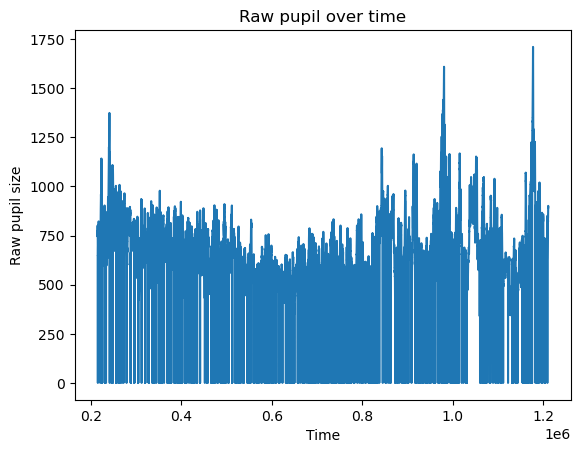

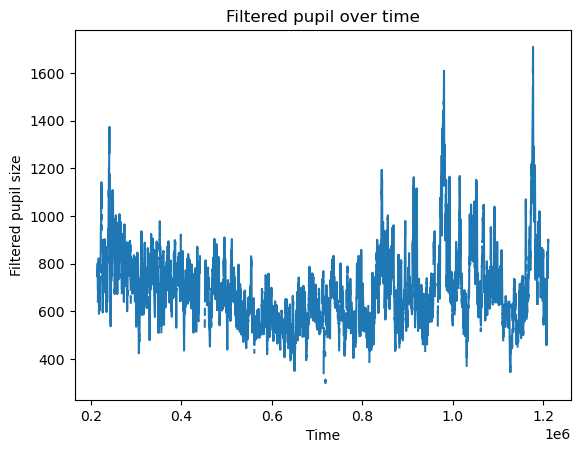

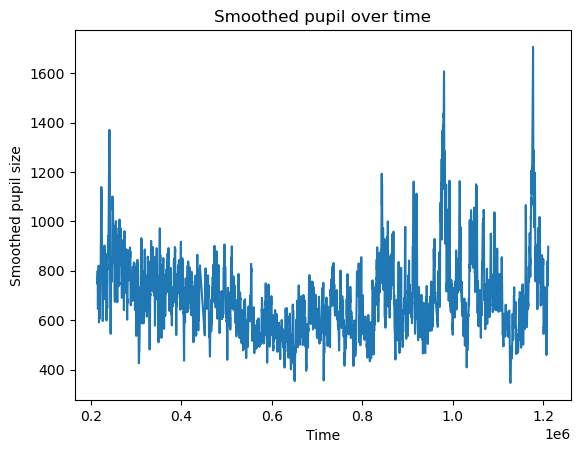

In [40]:
import matplotlib.pyplot as plt

#Raw pupil size over time
plt.plot(a.merged_data['time'].to_list(), a.merged_data['pupil'].to_list())
plt.title('Raw pupil over time')
plt.xlabel('Time')
plt.ylabel('Raw pupil size')
plt.show()

#Filtered pupil size over time
plt.plot(a.merged_data['time'].to_list(), a.merged_data['inter_pupil'].to_list())
plt.title('Filtered pupil over time')
plt.xlabel('Time')
plt.ylabel('Filtered pupil size')
plt.show()

#Smoothed pupil size over time
plt.plot(a.merged_data['time'].to_list(), a.merged_data['smoothed_interp_pupil'].to_list())
plt.title('Smoothed pupil over time')
plt.xlabel('Time')
plt.ylabel('Smoothed pupil size')
plt.show()

### Over one trial (block 0, trial 0) labeled by event

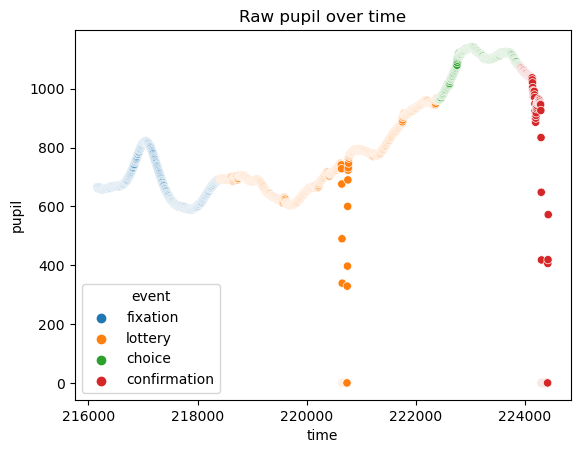

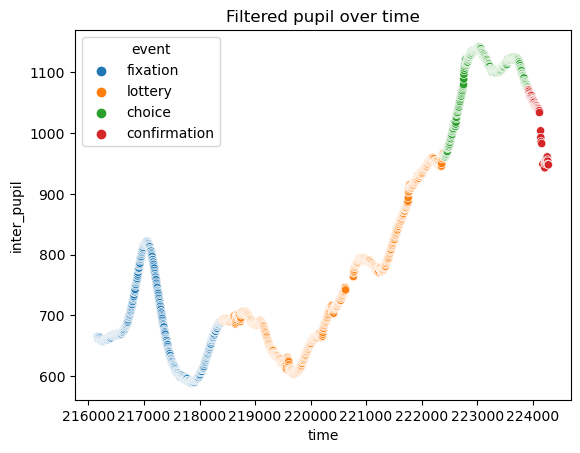

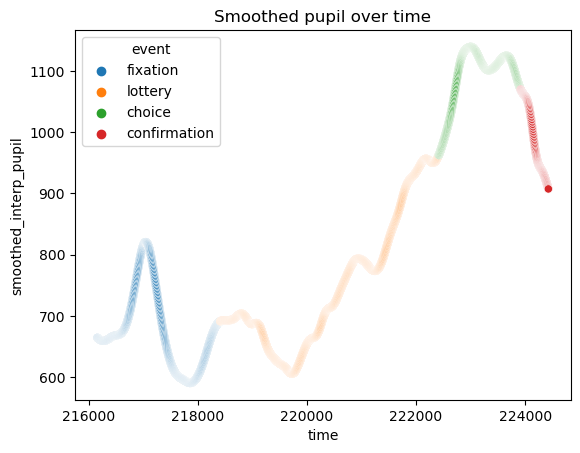

In [41]:
import seaborn as sns

#Filter dataframe to include block 0 and trial 0 only
filt = (a.merged_data['block'] == 0) & (a.merged_data['trial'] == 0)
a.merged_data_block0trial0 = a.merged_data[filt]

#Raw pupil size over time
raw_plot = sns.scatterplot(data=a.merged_data_block0trial0, x='time', y='pupil', hue='event')
raw_plot.set(title='Raw pupil over time')
plt.show()

#Filtered pupil size over time
filtered_plot = sns.scatterplot(data=a.merged_data_block0trial0, x='time', y='inter_pupil', hue='event')
filtered_plot.set(title='Filtered pupil over time')
plt.show()

#Smoothed pupil size over time
smoothed_plot = sns.scatterplot(data=a.merged_data_block0trial0, x='time', y='smoothed_interp_pupil', hue='event')
smoothed_plot.set(title='Smoothed pupil over time')
plt.show()

## Advanced preprocessing (relevant to task data)

In [89]:
#Run through advanced preprocessing functions
#(Note: the task dataframe used here was artificially generated below; run that code block BEFORE running this, and not after)
#(Note: skipped two functions, read_data_ready2use and choice_msgpupil_merge)

a.read_merged_and_task(task_df_name='/Users/emilydial/pypil/test_task_df.csv', overwrite=True)
    #(Note: overwrite=True since this function was run multiple times while testing)
a.add_first_row_pupil()
a.drop_redundant_column()
a.add_identifier()
a.add_timestamp()
a.avg_within_timewindow(timestamp_col='timestamp_locked_at_fixation', y_col='smoothed_interp_pupil')
a.percent_miss()
a.write_merged_and_task()
a.choice_msgpupil_merge(task_df='/Users/emilydial/pypil/test_task_df.csv', overwrite=True)

021 [merged pupil first row] data was OVERWRITTEN


/var/folders/67/1q1s53995qg3ml8dw6gm3nz80000gn/T/ipykernel_62143/196898899.py:935: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  self.merged_data = self.merged_data.groupby('identifier').apply(df_add_timestamp)


# Generate random choice data to use for advanced preprocessing 
## (Note: this was run before advanced preprocessing and not after)

In [3]:
def choice(df):
     
    output = np.random.randint(0,2, 1).astype(int)
    for i in output:
        choice_value = i
    
    return choice_value

g = a.merged_data.groupby(['block', 'trial'])
output_choice = g.apply(choice)
output_choice = output_choice.reset_index().rename(columns={0:'choice'})
a.merged_data = a.merged_data.merge(output_choice, on=['block', 'trial'])

print(a.merged_data)

task_df = a.merged_data[['ID', 'block', 'trial', 'choice']]
task_df = task_df.drop_duplicates(subset=['ID', 'block', 'trial'])
task_df.to_csv('test_task_df.csv')

           time        x        y  pupil dots  ID  block  trial         event  \
0        216162    637.3    506.5  665.0  ...  21    0.0    0.0      fixation   
1        216166    637.3    506.8  665.0  ...  21    0.0    0.0      fixation   
2        216170    638.2    506.8  664.0  ...  21    0.0    0.0      fixation   
3        216174    638.3    507.1  662.0  ...  21    0.0    0.0      fixation   
4        216178    637.4    507.3  664.0  ...  21    0.0    0.0      fixation   
...         ...      ...      ...    ...  ...  ..    ...    ...           ...   
248574  1210458    435.6    528.0  895.0  ...  21    3.0  119.0        choice   
248575  1210462    436.0    528.2  896.0  ...  21    3.0  119.0        choice   
248576  1210466    435.7    528.5  896.0  ...  21    3.0  119.0        choice   
248577  1210470    434.9    529.4  894.0  ...  21    3.0  119.0        choice   
248578  1210474    435.1    530.3  893.0  ...  21    3.0  119.0  confirmation   

        time_step  inter_pu